In [22]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geneclusters.cluster_genes import score_for_thres, get_kernighan_lin_clusters
from geneclusters.prepare_inputs import get_gene_pathway_matrix
from geneclusters.compute_stats import compute_t, compute_permuted_t, return_correlation_matrix, return_permutation_inputs, run_permutations, compute_permutation_p
from geneclusters.plotting import plot_permutations

In [23]:
cpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpu-1)

In [3]:
# run with internet
import gseapy
import numpy as np
x = gseapy.get_library('WikiPathway_2021_Human')
np.save('WikiPathway_2021_Human.npy', x)

ConnectionError: HTTPConnectionPool(host='maayanlab.cloud', port=80): Max retries exceeded with url: /Enrichr/datasetStatistics (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd34f7b7430>: Failed to establish a new connection: [Errno 101] Network is unreachable'))

In [9]:
# assign the clusters
frame = get_kernighan_lin_clusters('./examples/WikiPathway_2021_Human.npy', threshold=50, C=.5)
frame.columns = ['cluster', 'description', 'is_gene']
frame.to_csv('kernighan_clusters.csv', index = False)

4it [04:47, 71.96s/it, tot_impr=8620.0, last_impr=0, loss=2.23e+6]     


In [24]:
log_sampled = np.random.uniform(0,1, 20)
exp_transformed = np.exp(log_sampled)

In [ ]:
Nperm = 500
c = exp_transformed/np.max(exp_transformed)
pvalues = list()
for i in c:
    print('** '+str(i)+' **')
    frame = get_kernighan_lin_clusters('./examples/WikiPathway_2021_Human.npy', threshold=50, C=i)
    frame.columns = ['cluster', 'description', 'is_gene']
    permuted_t, observed_t = run_permutations('./examples/' + 'Ex' +'.csv', frame, Nperm)
    p = compute_permutation_p(permuted_t, observed_t)
    pvalues.append(p)

** 0.44573149691029484 **


4it [04:48, 72.25s/it, tot_impr=8.36e+3, last_impr=0, loss=1.99e+6]      


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
2+2

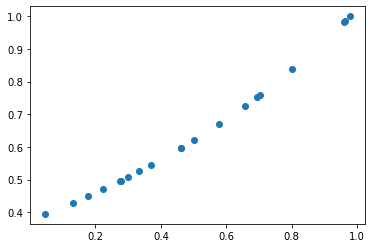

In [20]:
plt.scatter(log_sampled, exp_transformed/np.max(exp_transformed))

In [ ]:
# plot pvals by log c values to see how evolves
# what are the goals of this method and how can we benchmark it against other methods

** Ex **


  0%|          | 0/500 [00:00<?, ?it/s]

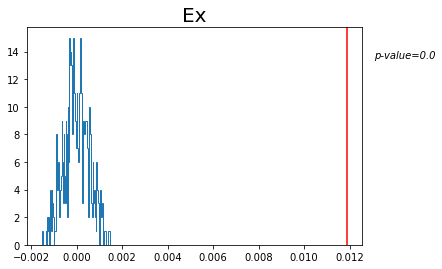

** In **


  0%|          | 0/500 [00:00<?, ?it/s]

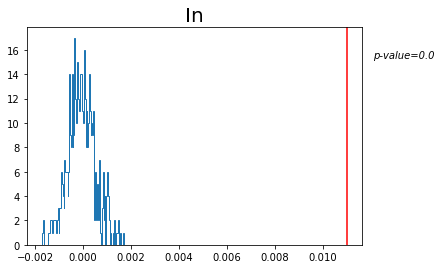

** Mic **


  0%|          | 0/500 [00:00<?, ?it/s]

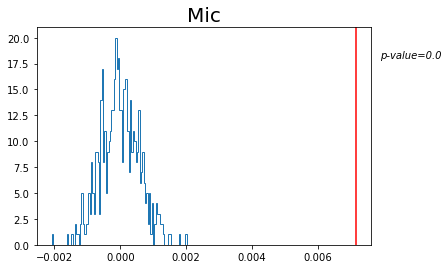

** Ast **


  0%|          | 0/500 [00:00<?, ?it/s]

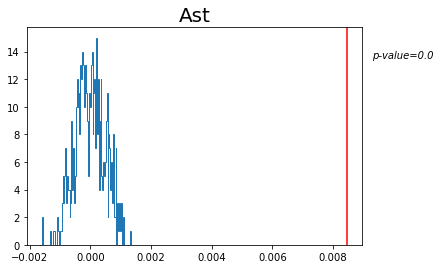

** Oli **


  0%|          | 0/500 [00:01<?, ?it/s]

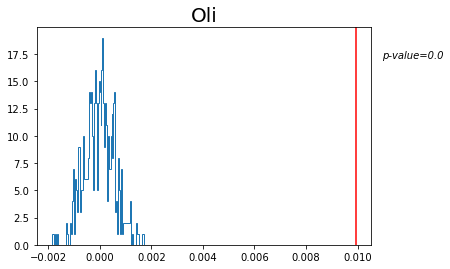

** Opc **


  0%|          | 0/500 [00:00<?, ?it/s]

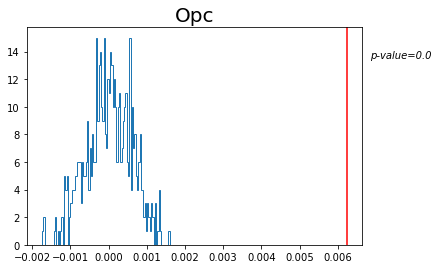

In [10]:
# evaluate observed correlations against Null
frame = pd.read_csv('kernighan_clusters.csv')
Nperm = 500

for name in np.array(['Ex', 'In', 'Mic', 'Ast', 'Oli', 'Opc']):
    print('** '+name+' **')
    permuted_t, observed_t = run_permutations('./examples/' + name +'.csv', frame, Nperm)
    p = compute_permutation_p(permuted_t, observed_t)
    plot_permutations(permuted_t, observed_t, p, Nperm, name)
    plt.show()

** Ex **


  0%|          | 0/500 [00:00<?, ?it/s]

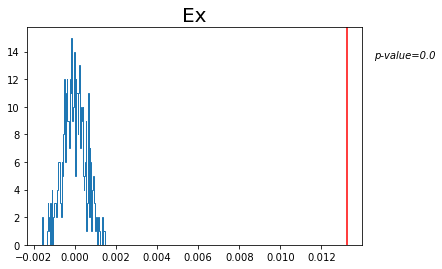

** In **


  0%|          | 0/500 [00:00<?, ?it/s]

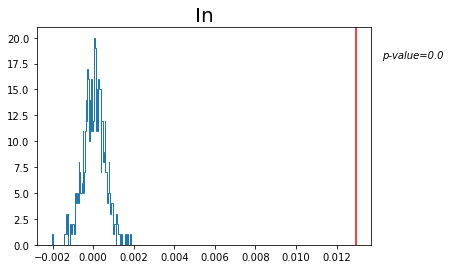

** Mic **


  0%|          | 0/500 [00:00<?, ?it/s]

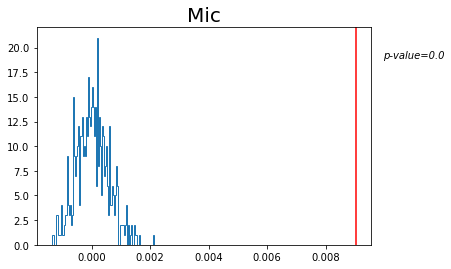

** Ast **


  0%|          | 0/500 [00:00<?, ?it/s]

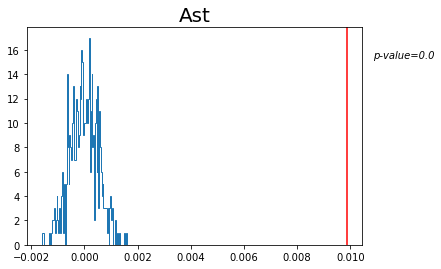

** Oli **


  0%|          | 0/500 [00:00<?, ?it/s]

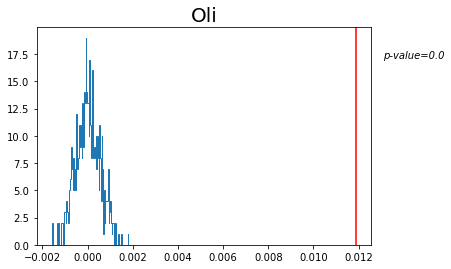

** Opc **


  0%|          | 0/500 [00:00<?, ?it/s]

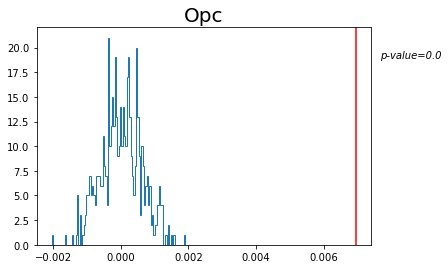

In [8]:
# evaluate observed correlations against Null
frame = pd.read_csv('kernighan_clusters.csv')
Nperm = 500

for name in np.array(['Ex', 'In', 'Mic', 'Ast', 'Oli', 'Opc']):
    print('** '+name+' **')
    permuted_t, observed_t = run_permutations('./examples/' + name +'.csv', frame, Nperm)
    p = compute_permutation_p(permuted_t, observed_t)
    plot_permutations(permuted_t, observed_t, p, Nperm, name)
    plt.show()

Text(0.5, 1.0, 'Astrocytes')

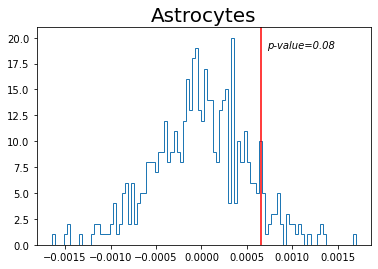

19.0

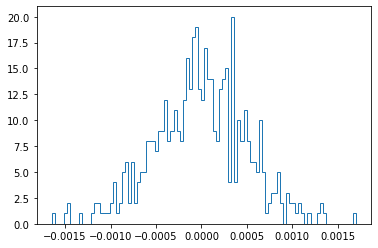

In [83]:
plot = plt.hist(np.array(permuted_t).reshape(-1), bins = int(.2*Nperm), histtype='step')


  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Astrocytes')

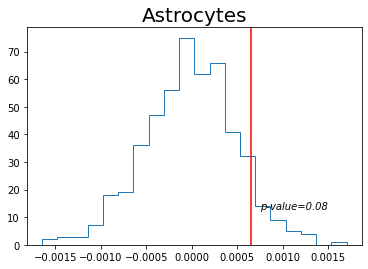

In [68]:
Nperm = 500
permuted_t, observed_t = run_permutations('./examples/Ast.csv', frame, Nperm)
p = compute_permutation_p(permuted_t, observed_t)



In [30]:
observed_t

[0.0006520923152769087]

In [17]:
def compute_many(all_correlations_indexed, partner1_cluster_anno, partner2_cluster_anno, u, index):
    np.random.seed()
    temp = np.random.permutation(all_correlations_indexed)
    x = compute_t(partner1_cluster_anno, partner2_cluster_anno, temp, u)
    return x

# def compute_t(partner1_cluster_anno, partner2_cluster_anno, all_correlations_indexed, u):
#     observed_ts = list()
#     for x in (range(len(u))):
#         in_genes = (partner1_cluster_anno==u[x]) & (partner2_cluster_anno==u[x])
#         out_genes = ((partner1_cluster_anno==u[x]) & (partner2_cluster_anno!=u[x]) | (partner1_cluster_anno!=u[x]) & (partner2_cluster_anno==u[x]))
#         observed_ts.append(np.mean(np.abs(all_correlations_indexed[in_genes]))-np.mean(np.abs(all_correlations_indexed[out_genes])))
#     return observed_ts

def compute_t(partner1_cluster_anno, partner2_cluster_anno, all_correlations_indexed, u):
    observed_ts = list()
    in_genes = (partner1_cluster_anno==partner2_cluster_anno)
    out_genes = np.invert(in_genes)
    observed_ts.append(np.mean(np.abs(all_correlations_indexed[in_genes]))-np.mean(np.abs(all_correlations_indexed[out_genes])))
    return observed_ts

### but the observations are not really IID in either case, right?
### don't count the same gene twice?

---

In [457]:
observed

[0.012805908948856692]

In [192]:
#func = partial(compute_many, all_correlations_indexed, partner1_cluster_anno, partner2_cluster_anno, u)
#tt = pool.map(func, np.array([0,1,2]))

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110112111114113115116117118119120121122123124126125127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

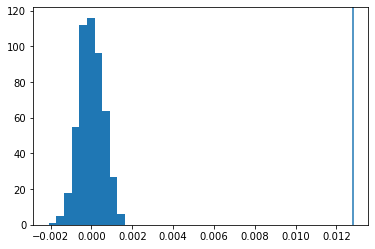

In [469]:
plt.hist(np.array(result_list).reshape(-1))
plt.axvline(observed)

In [312]:
null = np.array(result_list)
pvals = list()
for i in u:
    under_null = ECDF(null[:,i])
    p = 1-under_null(observed[i])
    pvals.append(p)

(array([49.,  6.,  2.,  5.,  6.,  4.,  2.,  1.,  1.,  4.,  2.,  2.,  0.,
         2.,  1.,  3.,  0.,  2.,  1.,  2.,  2.,  3.,  4.,  3.,  2.,  1.,
         0.,  0.,  1.,  0.,  1.,  1.,  1.,  3.,  3.,  1.,  2.,  2.,  1.,
         3.,  3.,  3.,  1.,  1.,  3.,  2.,  4.,  3.,  7.,  9.]),
 array([0.     , 0.01992, 0.03984, 0.05976, 0.07968, 0.0996 , 0.11952,
        0.13944, 0.15936, 0.17928, 0.1992 , 0.21912, 0.23904, 0.25896,
        0.27888, 0.2988 , 0.31872, 0.33864, 0.35856, 0.37848, 0.3984 ,
        0.41832, 0.43824, 0.45816, 0.47808, 0.498  , 0.51792, 0.53784,
        0.55776, 0.57768, 0.5976 , 0.61752, 0.63744, 0.65736, 0.67728,
        0.6972 , 0.71712, 0.73704, 0.75696, 0.77688, 0.7968 , 0.81672,
        0.83664, 0.85656, 0.87648, 0.8964 , 0.91632, 0.93624, 0.95616,
        0.97608, 0.996  ]),
 <BarContainer object of 50 artists>)

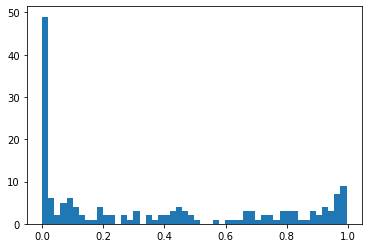

In [315]:
plt.hist(pvals, bins = 50)

In [337]:
import seaborn as sns
#sns.kdeplot(observed)
sns.boxplot(np.array(result_list[30])
#sns.boxplot(result_list[30])

AttributeError: 'list' object has no attribute 'reshape'

In [451]:
df = pd.DataFrame(((np.array(result_list[10]))))
df['grp'] = 'null'

In [452]:
df2 = pd.DataFrame(np.array(observed))
df2['grp'] = 'test'

<AxesSubplot:xlabel='grp', ylabel='0'>

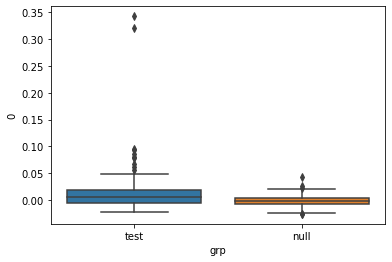

In [453]:
data = pd.concat((df2, df))
sns.boxplot(data = data, y=0, x = 'grp')#, hue = d['grp'])

<AxesSubplot:xlabel='grp', ylabel='vals'>

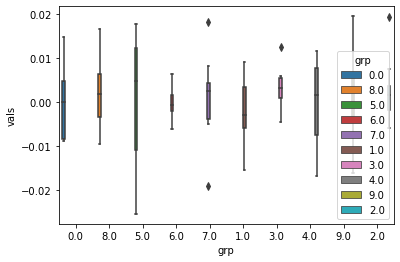

In [446]:
d = pd.DataFrame(np.concatenate((np.array(result_list[0:10]).reshape(-1,1), np.repeat(np.arange(10),165).reshape(-1,1)), axis = 1))
d.columns = ['vals', 'grp']
d['grp'] = d['grp'].astype(str)
d = d.loc[np.random.choice(range(d.shape[0]), 100,replace = False)]
sns.boxplot(data = d, y="vals", x = 'grp', hue = d['grp'])

,vals,grp
62320,0.008377,377.0
31807,-0.006221,192.0
23482,0.055481,142.0
74346,0.005122,450.0
71611,0.012171,434.0
...,...,...
19541,0.004841,118.0
52188,0.004307,316.0
34516,0.010602,209.0
63435,-0.003880,384.0


In [402]:
d['grp'] = pd.factorize(d['grp'])[0]

In [228]:
np.array(observed)

array([-0.03464488, -0.0258971 , -0.00869877, -0.00521359, -0.01373642,
       -0.03972672,  0.10169586,  0.0162953 , -0.01517552,  0.0021661 ,
       -0.01755502, -0.0228632 , -0.03696405,  0.02031774,  0.03094228,
       -0.0168851 ,  0.03684884, -0.03381413, -0.02609648,  0.01378928,
        0.04208353,  0.00122878, -0.00933959,  0.00836259, -0.01709072,
        0.02110433,  0.00726013,  0.00067163,  0.0332268 ,  0.06488785,
       -0.01599845,  0.00394366,  0.01202523,  0.02201726,  0.00955115,
        0.05638302,  0.01276292,  0.01338348, -0.03704986,  0.03668409,
        0.00253263,  0.03110318,  0.36142668,  0.02033578,  0.02762807,
        0.04645928,  0.03682482,  0.00454579,  0.04451779, -0.02550752,
       -0.00687384, -0.00248893, -0.04063303,  0.01577266,  0.03399732,
       -0.0076775 ,  0.00761983, -0.00969612,  0.03075439, -0.03674304,
       -0.01606204, -0.02367329,  0.0397613 ,  0.085336  , -0.01526923,
       -0.03338347,  0.01522796,  0.01235789,  0.07419206,  0.02

In [202]:
pool = Pool(processes=num_processes, initargs=(RLock(),), initializer=tqdm.set_lock)
pool

<multiprocessing.pool.Pool state=RUN pool_size=10>

Process ForkPoolWorker-2569:
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-2571:
Process ForkPoolWorker-2570:
Process ForkPoolWorker-2572:
Process ForkPoolWorker-2568:
Process ForkPoolWorker-2566:
Traceback (

In [169]:
import sys,time,random
def progressBar(count_value, total, suffix=''):
    init+=1
    bar_length = 100
    filled_up_Length = int(round(init* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()


In [171]:
init = 0
progressBar(1,10)

UnboundLocalError: local variable 'init' referenced before assignment

In [152]:

import time
import progressbar
 
widgets = [' [',
         progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
         '] ',
           progressbar.Bar('*'),' (',
           progressbar.ETA(), ') ',
          ]
 
bar = progressbar.ProgressBar(
                             ).start()
 
for i in range(200):
    time.sleep(0.1)
    bar.update(i)

ValueError: Value out of range

In [156]:
bar.update(1)


In [158]:
bar = progressbar.ProgressBar(
                             ).start()
func = partial(compute_many, all_correlations_indexed, partner1_cluster_anno, partner2_cluster_anno, u)
func(10)

[-0.007561895607224783,
 -0.005362912381868118,
 -0.01039697352077057,
 0.0004476376937357085,
 0.002177136553164677,
 -0.005500841883976287,
 -0.00493608277359503,
 0.007659607087030368,
 -0.0032511846780335363,
 -0.0050210768628818625,
 -0.009038417737303961,
 0.01023554541071564,
 0.007104761029459894,
 -0.0066552588087253894,
 0.004074070017132003,
 -0.013780222761681699,
 -0.0058024232866525915,
 -0.007733251424825505,
 -0.0066445672441578785,
 -0.00035626553860759747,
 0.0032949598965416604,
 -0.0030740763393641846,
 0.004824654663111133,
 -0.006434969040669064,
 0.020804096304355535,
 0.0020363738574761814,
 -0.01607338794083163,
 -0.010049043608528957,
 0.00016167112517082027,
 -0.0065808628567116945,
 -0.0020978343044791015,
 -0.00024268426381873764,
 -0.0045345844214861875,
 -0.001028420035708022,
 0.009836570102766229,
 0.02194182034033368,
 0.004092896811114327,
 0.007467580563406101,
 0.0002209537896785685,
 0.0009413054620949768,
 0.013380083225440376,
 0.0074317171669028

In [127]:
range(len(u))

range(0, 165)

In [54]:

def error_callback(result):
    print("Error!")

def done_callback(result):
    print("Done. Result: ", result)

In [111]:
numbers = list(range(10))
func = partial(compute_many, all_correlations_indexed, partner1_cluster_anno, partner2_cluster_anno, u)
initial_tasks = [(compute_many,(i,)) for i in [1]]

In [112]:
initial_tasks

[(<function __main__.compute_many(all_correlations_indexed, partner1_cluster_anno, partner2_cluster_anno, u, index)>,
  (1,))]

In [ ]:
pool = TqdmMultiProcessPool(cpu-1)
process_count = cpu-1
with tqdm.tqdm(total=5, dynamic_ncols=False) as global_progress:
        global_progress.set_description("global")
        res = pool.map(global_progress, initial_tasks, error_callback, done_callback)

global:   0%|          | 0/5 [00:00<?, ?it/s]


In [86]:
from time import sleep
import multiprocessing
import tqdm

import logging
from tqdm_multiprocess.logger import setup_logger_tqdm
logger = logging.getLogger(__name__)

from tqdm_multiprocess import TqdmMultiProcessPool

In [ ]:
res = pool.map(global_tqdm = global_progress,tasks = initial_tasks, on_error = error_callback, on_done = done_callback)
res

In [62]:
import multiprocessing
import tqdm
from tqdm_multiprocess.logger import setup_logger_tqdm
from tqdm_multiprocess import TqdmMultiProcessPool



In [13]:
observed_ts = list()
u = np.unique(partner2_cluster_anno)
for x in tqdm(range(len(u))):
    in_genes = (partner1_cluster_anno==u[x]) & (partner2_cluster_anno==u[x])
    out_genes = np.invert(in_genes)
    observed_ts.append(np.mean(all_correlations_indexed[in_genes])-np.mean(all_correlations_indexed[out_genes]))

100%|██████████| 165/165 [00:11<00:00, 14.56it/s]


In [79]:
func = partial(compute_many, all_correlations_indexed, partner1_cluster_anno, partner2_cluster_anno, u)

In [80]:
func(1)

[-0.011981243545079262,
 -0.0026194433113432836,
 -0.004452536243850752,
 0.0007117180130159217,
 0.006592478995029738,
 -0.007491161699376914,
 -0.00197572111382166,
 -0.005112792643566316,
 -0.006024580250690997,
 -0.0024245936140749047,
 -0.0036758019625335314,
 0.00338652436360537,
 0.005945488806614219,
 0.0029942935779037616,
 0.02232990150873712,
 0.006733256528479559,
 0.009924541190351494,
 -0.016828791540665272,
 -0.004558521402840937,
 -0.0019167331013128786,
 -0.0004172738809700427,
 0.0007640341555232577,
 -0.00014827764443356428,
 -0.011559925711469132,
 0.0160187910262288,
 -0.0010744030545560002,
 0.0018647751930077339,
 -0.006239884730806139,
 0.002763005236486843,
 -0.0032281087384778695,
 0.005234984979715668,
 0.008133195423860123,
 0.008952905474842981,
 -0.0034713809637212656,
 -0.01193954157518945,
 -0.004227111327119254,
 -0.004310467080310659,
 -1.1142093530064345e-05,
 0.0048633300249008304,
 -0.0019203786687913282,
 -0.012546928077300429,
 0.00410564761836126

100%|██████████| 165/165 [00:14<00:00, 11.65it/s]


In [195]:
outputs = np.zeros((1000, 165))
for x in tqdm(range(1000)):
    temp = np.random.permutation(all_correlations_indexed)
    outputs[x] = compute_t(partner1_cluster_anno, partner2_cluster_anno, temp, u)

  0%|          | 1/1000 [00:21<5:58:56, 21.56s/it]


KeyboardInterrupt: 

In [166]:
compute_t_partial = partial(compute_t, partner1_cluster_anno, partner2_cluster_anno, all_correlations_indexed)

In [170]:
compute_t_partial(u[10])

-0.012574776705748178

In [174]:
numbers = np.unique(partner2_cluster_anno)
import multiprocessing
cpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpu-1)
out = pool.map(compute_t_partial, numbers)

Process ForkPoolWorker-55:
Process ForkPoolWorker-22:
Process ForkPoolWorker-49:
Process ForkPoolWorker-54:
Process ForkPoolWorker-50:
Process ForkPoolWorker-24:
Process ForkPoolWorker-52:
Process ForkPoolWorker-64:
Process ForkPoolWorker-45:
Process ForkPoolWorker-25:
Process ForkPoolWorker-41:
Process ForkPoolWorker-44:
Process ForkPoolWorker-40:
Process ForkPoolWorker-39:
Process ForkPoolWorker-42:
Process ForkPoolWorker-31:
Process ForkPoolWorker-38:
Process ForkPoolWorker-32:
Process ForkPoolWorker-21:
Process ForkPoolWorker-63:
Process ForkPoolWorker-7:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-59:
Process ForkPoolWorker-89:
Process ForkPoolWorker-56:
Process ForkPoolWorker-62:
Process ForkPoolWorker-60:
Process ForkPoolWorker-86:
Process ForkPoolWorker-19:
Process ForkPoolWorker-66:
Process ForkPoolWorker-58:
Process ForkPoolWorker-87:
Process ForkPoolWorker-69:
Process ForkPoolWorker-35:
Process ForkPoolWorker-78:
Process ForkPoolWorker-53:
Pro

KeyboardInterrupt: 

Process ForkPoolWorker-30:
Process ForkPoolWorker-65:
Process ForkPoolWorker-36:
Process ForkPoolWorker-84:
Process ForkPoolWorker-67:
Process ForkPoolWorker-61:
Process ForkPoolWorker-29:
Process ForkPoolWorker-76:
Process ForkPoolWorker-73:
Process ForkPoolWorker-80:
Process ForkPoolWorker-16:
Process ForkPoolWorker-72:
Process ForkPoolWorker-83:
Process ForkPoolWorker-85:
Process ForkPoolWorker-18:
Process ForkPoolWorker-92:
Process ForkPoolWorker-13:
Process ForkPoolWorker-70:
Process ForkPoolWorker-68:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-14:
Process ForkPoolWorker-81:
Process ForkPoolWorker-82:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-33:
Process ForkPoolWorker-94:
Process ForkPoolWorker-90:
Process ForkPoolWorker-74:
Process ForkPoolWorker-71:
Process ForkPoolWorker-95:
Process ForkPoolWorker-88:
Process ForkPoolWorker-10:
Process ForkPoolWorker-46:
Traceback (most recent call last)

In [62]:
partner_1_final_index = [[x in all_cluster_members[y] for x in partner1_indexed] for y in clus_unique]

KeyboardInterrupt: 

In [ ]:
partner_1_final_index = [[x in all_cluster_members[y] for x in partner1_indexed] for y in clus_unique]

In [ ]:
import multiprocessing
cpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpu-1)
f = partial(compute_pval, frame_gene, correlations, names, 500)
clusters = np.unique(frame_gene[0])
#clusters = np.array(random.sample(set(clusters), 25))
out = pool.map(f, clusters)

 33%|███▎      | 164/500 [03:10<10:17,  1.84s/it]Process ForkPoolWorker-15789:
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/connection.py", 

In [59]:
def compute_pval(frame_gene, correlations, names, nperm, cluster):
    index = frame_gene[0]==cluster
    in_genes = set(frame_gene['description'][index])
    out_genes = set(frame_gene['description'][np.invert(index)])
    obs_t = compute_t_instance(in_genes, out_genes, correlations, names, False, 1)
    x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)
    results = list()
    for i in tqdm(range(nperm)):
        results.append(x(i))
    under_null = ECDF(results)
    p = 1-under_null(obs_t)
    return p

def compute_t(correlations, index_in, index_out):
    df_in = correlations[index_in,index_in]
    xm = np.nanmean(np.abs(np.tril(df_in, k = -1)))
    df_out = correlations[index_out,index_out]
    yn = np.nanmean(np.abs(np.tril(df_out, k = -1)))
    t = xm-yn
    return t

def compute_t_instance(in_genes, out_genes, correlations, names, permute, iteration):
    if permute:
        np.random.seed()
        temp_names = np.random.permutation(names)
        #print(temp_names)
    else:
        temp_names = names
    index_in = [x in in_genes for x in temp_names]
    index_out = [x in out_genes for x in temp_names]
    t_obs = compute_t(correlations, index_in, index_out)
    return t_obs

In [63]:
f(1)

  0%|          | 0/500 [00:00<?, ?it/s]Process ForkPoolWorker-15548:
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: invalid load key, '\xf5'.
Process ForkPoolWorker-15553:
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/state/partition1/

KeyboardInterrupt: 

Process ForkPoolWorker-15579:
Process ForkPoolWorker-15587:
Traceback (most recent call last):
Process ForkPoolWorker-15549:
Process ForkPoolWorker-15550:
Process ForkPoolWorker-15563:
Process ForkPoolWorker-15558:
Process ForkPoolWorker-15557:
Process ForkPoolWorker-15547:
Process ForkPoolWorker-15642:
Process ForkPoolWorker-15600:
Process ForkPoolWorker-15581:
Process ForkPoolWorker-15580:
Process ForkPoolWorker-15596:
Process ForkPoolWorker-15590:
Process ForkPoolWorker-15588:
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-15582:
Process ForkPoolWorker-15664:
Process ForkPoolWorker-15593:
Traceback (most recent call last):
Process ForkPoolWorker-15667:
Process ForkPoolWorker-15602:
Process ForkPoolWorker-15589:
Process ForkPoolWorker-15545:
Process ForkPoolWorker-15554:
Process ForkPoolWorker-15552:
Process ForkPoolWorker-15591:
Process ForkPoolWorker-15585:
Proces

In [58]:
c = np.array(correlations)
c[np.where(index),np.where(index)]

array([[ 1.,  1., nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [246]:
unique_clusters = np.unique(frame_gene[0])
clus = unique_clusters
pvalues = list()
for cluster in tqdm(range(len(clus))):
    cluster = clus[cluster]
    index = frame_gene[0]==cluster
    in_genes = set(frame_gene['description'][index])
    out_genes = set(frame_gene['description'][np.invert(index)])
    obs_t = compute_t_instance(in_genes, out_genes, correlations, names, False, 1)
    x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)
    results = list()
    for i in (range(100)):
        results.append(x(i))
    #x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)
    #results = process_map(x, np.array(range(2)))
    under_null = ECDF(results)
    p = 1-under_null(obs_t)
    pvalues.append(p)

  1%|          | 3/312 [05:09<8:50:29, 103.01s/it]


KeyboardInterrupt: 

In [ ]:
unique_clusters = np.unique(frame_gene[0])
clus = unique_clusters
pvalues = list()
for cluster in tqdm(range(len(clus))):
    cluster = clus[cluster]
    index = frame_gene[0]==cluster
    in_genes = set(frame_gene['description'][index])
    out_genes = set(frame_gene['description'][np.invert(index)])
    obs_t = compute_t_instance(in_genes, out_genes, correlations, names, False, 1)
    x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)
    results = list()
    for i in (range(100)):
        results.append(x(i))
    #x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)
    #results = process_map(x, np.array(range(2)))
    under_null = ECDF(results)
    p = 1-under_null(obs_t)

In [264]:
#y = partial(compute_pval, frame_gene, correlations, names, 10)
#process_map(y, np.array([2,5]))

In [272]:
pvalues = list()
for cluster in tqdm(range(len(clus))):
    pvalues.append(compute_pval(frame_gene, correlations, names, 2, 0))

  1%|          | 2/312 [00:07<18:21,  3.55s/it]


KeyboardInterrupt: 

In [216]:
x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)

In [231]:
import timeit

In [235]:
starttime = timeit.default_timer()
results = process_map(x, np.array(range(50)))#max_workers = multiprocessing.cpu_count()-10)
print(timeit.default_timer()-starttime)

  0%|          | 0/50 [00:01<?, ?it/s]

203.9917749479646


In [237]:
starttime = timeit.default_timer()
for i in tqdm(range(50)):
    x(i)#, #max_workers = multiprocessing.cpu_count()-10)
print(timeit.default_timer()-starttime)

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

45.64024406799581


In [208]:
results = process_map(x, np.array([1]))

  0%|          | 0/1 [00:01<?, ?it/s]

['CFAP46' 'GYPA' 'LRRC20' ... 'RPL23A' 'ACP6' 'ERN1']


In [204]:
results

[0.023776612592105895]

In [223]:
help(process_map)

Help on function process_map in module tqdm.contrib.concurrent:

process_map(fn, *iterables, **tqdm_kwargs)
    Equivalent of `list(map(fn, *iterables))`
    driven by `concurrent.futures.ProcessPoolExecutor`.
    
    Parameters
    ----------
    tqdm_class  : optional
        `tqdm` class to use for bars [default: tqdm.auto.tqdm].
    max_workers  : int, optional
        Maximum number of workers to spawn; passed to
        `concurrent.futures.ProcessPoolExecutor.__init__`.
        [default: min(32, cpu_count() + 4)].
    chunksize  : int, optional
        Size of chunks sent to worker processes; passed to
        `concurrent.futures.ProcessPoolExecutor.map`. [default: 1].
    lock_name  : str, optional
        Member of `tqdm_class.get_lock()` to use [default: mp_lock].



100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


0.12

(array([ 2.,  0.,  0.,  4.,  0.,  1.,  1.,  1.,  3.,  3.,  6.,  3.,  6.,
         8.,  7.,  9.,  7., 11.,  9., 18., 24., 15., 20., 29., 25., 30.,
        36., 27., 30., 34., 31., 25., 37., 35., 28., 28., 32., 29., 29.,
        30., 16., 28., 28., 19., 22., 21., 19., 20., 12., 14., 10., 14.,
        11., 12., 12.,  9.,  7., 12.,  7.,  7.,  5.,  1.,  4.,  1.,  1.,
         1.,  2.,  4.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.0304711 , -0.02972457, -0.02897805, -0.02823152, -0.027485  ,
        -0.02673848, -0.02599195, -0.02524543, -0.0244989 , -0.02375238,
        -0.02300585, -0.02225933, -0.0215128 , -0.02076628, -0.02001976,
        -0.01927323, -0.01852671, -0.01778018, -0.01703366, -0.01628713,
        -0.01554061, -0.01479408, -0.01404756, -0.01330104, -0.01255451,
        -0.01180799, -0.01106146, -0.01031494, -0.00956841, -0.008821

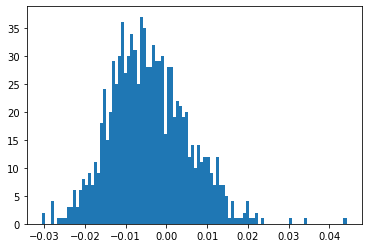

In [163]:
plt.hist(out, bins = 100)

In [84]:
out = process_map(, np.array([True, True]))

  0%|          | 0/2 [00:00<?, ?it/s]

['C8orf37' 'LTBP2' 'DDX53' ... 'DYNC2H1' 'INPP4A' 'DKK1']
['C8orf37' 'LTBP2' 'DDX53' ... 'DYNC2H1' 'INPP4A' 'DKK1']


In [ ]:
out = process_map(partial(compute_t_instance, in_genes, out_genes, correlations, names, True), np.array([True, True]))

  0%|          | 0/2 [00:01<?, ?it/s]

In [137]:
import multiprocessing


96

In [118]:

from multiprocessing import Pool
pool = Pool(processes=6)

Process ForkPoolWorker-513:
Traceback (most recent call last):
Process ForkPoolWorker-516:
Process ForkPoolWorker-518:
Process ForkPoolWorker-515:
Process ForkPoolWorker-514:
Process ForkPoolWorker-517:
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with se

In [138]:
x = partial(compute_t_instance, in_genes, out_genes, correlations, names, True)
out = process_map(x, range(100), max_workers=multiprocessing.cpu_count())

  0%|          | 0/100 [00:00<?, ?it/s]

In [142]:
seed = 0
# create the RNG that you want to pass around
rng = np.random.default_rng(seed)
# get the SeedSequence of the passed RNG
ss = rng.bit_generator._seed_seq
# create 5 initial independent states
child_states = ss.spawn(5)

In [144]:
child_states[0]

SeedSequence(
    entropy=0,
    spawn_key=(0,),
)

In [131]:
out

[-0.005562747737874574]

In [106]:
import random
from tqdm import tqdm

In [112]:
x = partial(compute_t_instance, in_genes, out_genes, correlations, names)

In [113]:
out = list()
for i in tqdm(range(1000)):
    out.append(x(True))

 27%|██▋       | 266/1000 [04:04<11:15,  1.09it/s]


KeyboardInterrupt: 

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 2., 3., 2., 3.,
        2., 1., 1., 0., 4., 1., 0., 6., 1., 0., 2., 1., 3., 2., 3., 0., 0.,
        1., 0., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([-0.02533006, -0.02435981, -0.02338956, -0.02241931, -0.02144906,
        -0.02047881, -0.01950856, -0.01853831, -0.01756806, -0.0165978 ,
        -0.01562755, -0.0146573 , -0.01368705, -0.0127168 , -0.01174655,
        -0.0107763 , -0.00980605, -0.0088358 , -0.00786555, -0.0068953 ,
        -0.00592505, -0.0049548 , -0.00398455, -0.0030143 , -0.00204405,
        -0.0010738 , -0.00010355,  0.0008667 ,  0.00183695,  0.0028072 ,
         0.00377745,  0.0047477 ,  0.00571795,  0.0066882 ,  0.00765845,
         0.0086287 ,  0.00959895,  0.0105692 ,  0.01153945,  0.01250971,
         0.01347996,  0.01445021,  0.01542046,  0.01639071,  0.01736096,
         0.01833121,  0.01930146,  0.02027171,  0.02124196,  0.02221221,
         0.02318246]),
 <BarContainer object

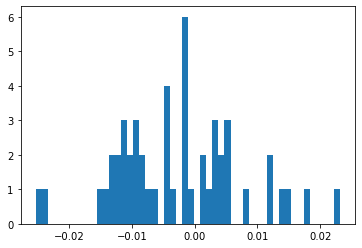

In [103]:
import matplotlib.pyplot as plt
plt.hist(out, bins = 50)

In [ ]:
# compute empirical CDF

In [38]:
compute_t_instance(in_genes, out_genes, correlations, names, permute=True)

-0.007329543560770674

In [52]:
plt.hist(

In [77]:
t


-0.022704652270552905

In [29]:
# what should this clustering algorithm do? 
### Combine functionally-related genes
### Genes in the same cluster should show higher functional-relatedness than genes that are not in a particular cluster

### what metric are we going to evaluate against? and what clustering methods are we going to compare against?

,0,description,is_gene
0,178,A3GALT2,True
1,138,A4GALT,True
2,234,AADAT,True
3,212,AAMP,True
4,157,AANAT,True
...,...,...,...
7790,89,Wnt signaling pathway and pluripotency WP399,False
7791,206,Wnt Signaling Pathway WP363,False
7792,199,Wnt signaling WP428,False
7793,186,Wnt/beta-catenin signaling pathway in leukemia...,False


In [32]:
# write down the math for this stats test --> permutation testing
np.unique(results[1])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18